In [1]:
# Data manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
import xgboost as xgb

# Data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Transformers and NLP utilities
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from hazm import Normalizer

# Deep learning
import torch


In [2]:
train_imbalance = pd.read_csv('./../data/task_train.csv')
test_imbalance = pd.read_csv('./../data/task_test.csv')

In [3]:
test_imbalance.drop(columns=['Unnamed: 0.1','Unnamed: 0'] , inplace=True)
train_imbalance.drop(columns=['Unnamed: 0.1','Unnamed: 0'] , inplace=True)

In [4]:
train_imbalance.head()

,ID,UserID,Origin,Destination,Time,Income,Comment,Created_at,Label
0,1001034,1001513,1030,1030,9,230000,\n,2024-04-13 10:07:38.022905,0
1,1005544,1001129,631,847,42,1060000,راننده بسیار مودب بود و خوشرو بود\n,2024-04-15 12:15:10.609723,0
2,1000139,1004333,858,864,34,1250000,سفر بسیار اسان و راحتی بود، و ماشین تمیزتمیز ...,2024-04-13 02:18:36.600126,0
3,1000560,1001673,593,846,14,660000,راننده به موقع رسید\n,2024-04-13 06:00:18.870376,1
4,1008230,1002231,1018,1018,11,230000,ماشین بسیار شیک بود و راننده از هر لحاظ حرفه...,2024-04-16 16:31:47.874442,0


In [5]:
train_imbalance.dropna(inplace=True)
test_imbalance.dropna(inplace=True)

# feature engineering 1: cost per trip duration

In [6]:
train_imbalance['costpermin'] = (train_imbalance['Income'] / (train_imbalance['Time'] + .001)).astype(int)
test_imbalance['costpermin'] = (test_imbalance['Income'] / (test_imbalance['Time'] + .001)).astype(int)

# feature engineering 2: comment analysis

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Replace with your chosen model
model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-digikala"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

normalizer = Normalizer()


def preprocess_text(text):
    # Normalize the text
    text = normalizer.normalize(text)
    return text


def analyze_sentiment(text):
    # Preprocess the text
    text = preprocess_text(text)

    # Tokenize and encode the text
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_tensors="pt",
        truncation=True,
        padding='max_length',
        max_length=128
    )

    # Get model predictions
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
        )
        logits = outputs.logits

    # Get the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map the predicted class to sentiment label
    sentiment_labels = {0: 'Negative', 1: 'Positive'}
    sentiment = sentiment_labels.get(predicted_class, 'Unknown')
    return sentiment


train_imbalance['comment-analysis'] = train_imbalance['Comment'].apply(analyze_sentiment)
test_imbalance['comment-analysis'] = test_imbalance['Comment'].apply(analyze_sentiment)

train_imbalance['comment-analysis'] = train_imbalance['comment-analysis'].replace('Unknown', 0).replace("Positive", 1).replace("Negative", -1)
test_imbalance['comment-analysis'] = test_imbalance['comment-analysis'].replace('Unknown', 0).replace("Positive", 1).replace("Negative", -1)

/home/aj/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# feature engineering 3: Convert 'Created_at' to a useful datetime feature

In [8]:
train_imbalance['Created_at'] = pd.to_datetime(train_imbalance['Created_at'])
train_imbalance['Created_hour'] = train_imbalance['Created_at'].dt.hour
train_imbalance.drop(columns=['Created_at', 'ID', 'UserID'], inplace=True)

In [9]:
test_imbalance['Created_at'] = pd.to_datetime(test_imbalance['Created_at'])
test_imbalance['Created_hour'] = test_imbalance['Created_at'].dt.hour
test_imbalance.drop(columns=['Created_at', 'ID', 'UserID'], inplace=True)

# EDA

(array([1681., 2371., 1718., 1243.,  664.,  388.,  187.,  108.,   53.,
          40.,   23.,   12.,    3.,    5.,    4.]),
 array([  0.        ,   8.93333333,  17.86666667,  26.8       ,
         35.73333333,  44.66666667,  53.6       ,  62.53333333,
         71.46666667,  80.4       ,  89.33333333,  98.26666667,
        107.2       , 116.13333333, 125.06666667, 134.        ]),
 <BarContainer object of 15 artists>)

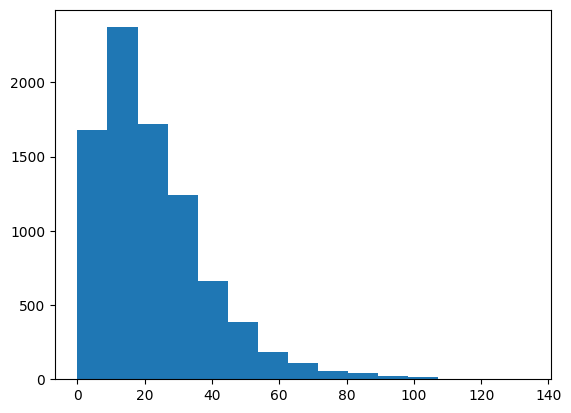

In [10]:
plt.hist(train_imbalance["Time"], bins=15)

(array([2677., 1790., 1527., 1044.,  677.,  354.,  180.,   98.,   56.,
          38.,   34.,   13.,    4.,    4.,    4.]),
 array([ 180000.        ,  421333.33333333,  662666.66666667,
         904000.        , 1145333.33333333, 1386666.66666667,
        1628000.        , 1869333.33333333, 2110666.66666667,
        2352000.        , 2593333.33333333, 2834666.66666667,
        3076000.        , 3317333.33333333, 3558666.66666667,
        3800000.        ]),
 <BarContainer object of 15 artists>)

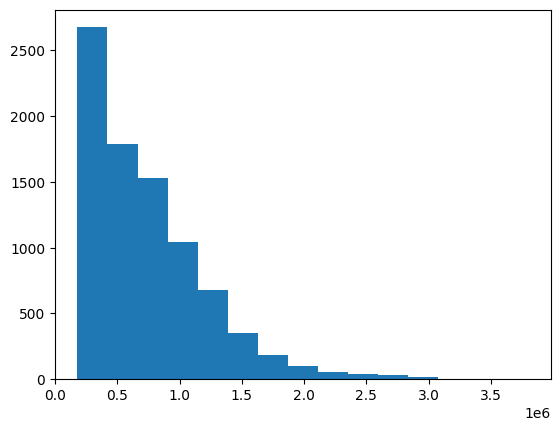

In [11]:
plt.hist(train_imbalance["Income"], bins=15)

In [12]:
# correlation of features and label
df_train = train_imbalance.drop(columns=["Comment"])
correlation_matrix = df_train.corr()

correlation_with_label = correlation_matrix['Label'].sort_values(ascending=False)

print(correlation_with_label)

Label               1.000000
costpermin          0.025272
Created_hour        0.005379
Origin              0.004199
comment-analysis   -0.002985
Destination        -0.019550
Income             -0.092474
Time               -0.099044
Name: Label, dtype: float64


<Axes: >

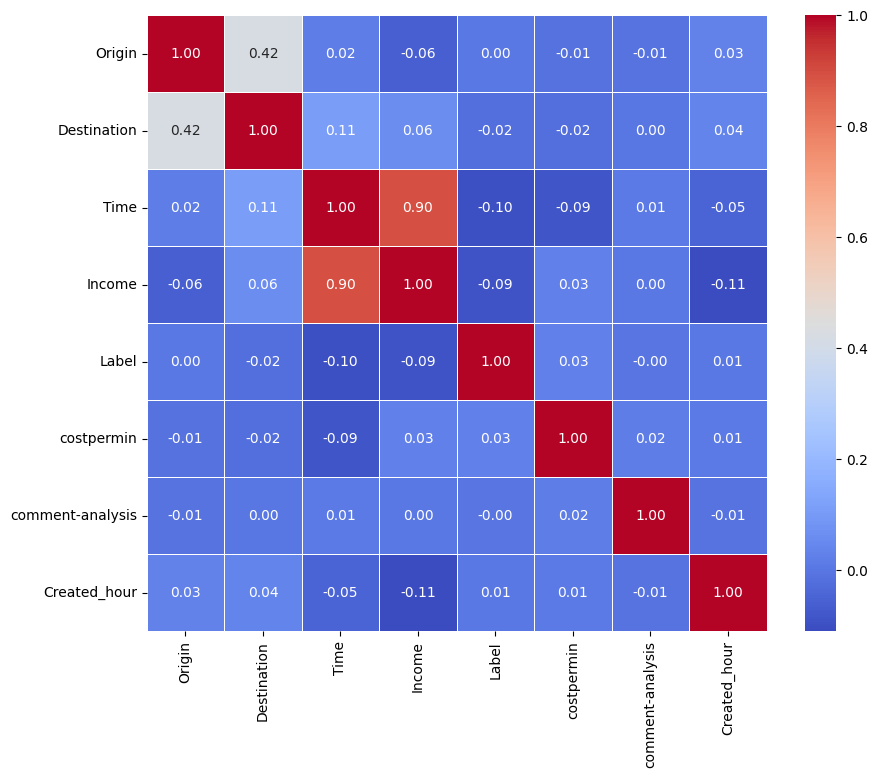

In [13]:
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# feature selection

In [14]:
# Features and target
X = train_imbalance.drop(columns=['Label','Comment'])
y = train_imbalance['Label']

X_test = test_imbalance.drop(columns=['Label','Comment'])
y_test = test_imbalance['Label']

In [15]:
train_imbalance['Label'].value_counts()

Label
0    8311
1     189
Name: count, dtype: int64

# balance data with SMOTE and under sampling:

SMOTE was tested but the results were lower compared to undersampling method.

In [16]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X, y)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X, y)

In [17]:
len(X_train)

378

# Random Forest

In [18]:
param_grid = {
    "n_estimators": [90, 100, 110, 120],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_split": [2, 3, 4, 5],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [90, 100, 110, 120]},
             scoring='roc_auc', verbose=1)

In [19]:
print("Best parameters found RF: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found RF:  {'criterion': 'gini', 'min_samples_split': 3, 'n_estimators': 90}
Best score:  0.7196619749943849


# XGBoost

In [20]:
param_grid = {
    'n_estimators': [90, 100, 110, 120],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
}
xgb_clf = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=2, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [90, 100, 110, 120],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc', verbose=1)

In [21]:

# Print the best parameters and best score
print("Best parameters found XG: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found XG:  {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
Best score:  0.6994960806270996


# feature importance

In [22]:
# Initialize an empty list to store the feature names and corresponding AUC scores
feature_auc_scores = []

# Loop over each feature and progressively add them
best_model, best_auc, best_features = None, 0, None
for i in range(1, X_train.shape[1] + 1):
    # Select the first i columns/features
    selected_features = X_train.columns[:i]

    # Train the RandomForestClassifier
    rf = RandomForestClassifier(criterion='gini', min_samples_split=3, n_estimators=90, random_state=42)
    rf.fit(X_train[selected_features], y_train)

    # Make probability predictions on the test set
    y_proba = rf.predict_proba(X_test[selected_features])[:, 1]

    # Calculate the AUC score
    auc_value = roc_auc_score(y_test, y_proba)

    # Store the feature name and its corresponding AUC score
    feature_auc_scores.append((list(selected_features), auc_value))

    # Select the best model
    if auc_value > best_auc:
        best_auc = auc_value
        best_model = rf
        best_features = selected_features
    print(f"Features: {list(selected_features)} => AUC: {auc_value:.4f}")


Features: ['Origin'] => AUC: 0.5580
Features: ['Origin', 'Destination'] => AUC: 0.5498
Features: ['Origin', 'Destination', 'Time'] => AUC: 0.6810
Features: ['Origin', 'Destination', 'Time', 'Income'] => AUC: 0.7259
Features: ['Origin', 'Destination', 'Time', 'Income', 'costpermin'] => AUC: 0.7559
Features: ['Origin', 'Destination', 'Time', 'Income', 'costpermin', 'comment-analysis'] => AUC: 0.7633
Features: ['Origin', 'Destination', 'Time', 'Income', 'costpermin', 'comment-analysis', 'Created_hour'] => AUC: 0.7096


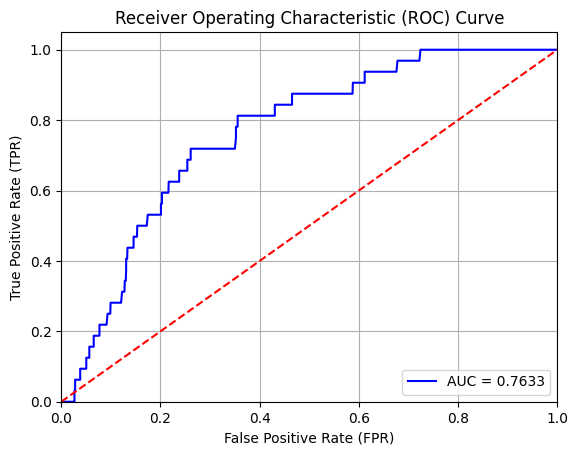

In [23]:
y_proba = best_model.predict_proba(X_test[best_features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()